<a href="https://colab.research.google.com/github/PGPradhan/Sales-Forecasting/blob/sales-story/Sales_Forcasting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [3]:
df = pd.read_csv('/content/Forecasting.csv')
df

,date,total_quantity
0,12-10-2016,1
1,12-09-2016,1
2,13-09-2016,1
3,23-09-2016,4
4,23-09-2016,5
...,...,...
988,16-02-2024,4
989,15-02-2024,7
990,15-02-2024,13
991,16-02-2024,9


In [4]:

df.isnull().sum()

date              1
total_quantity    0
dtype: int64

In [5]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with a 'date' column
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')  # Convert date column to datetime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)  # Adjust the date range as per your data
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)  # Adjust the date range as per your data

train_df.head()


,date,total_quantity,year,month,day,weekday
0,2016-10-12,1,2016.0,10.0,12.0,2.0
1,2016-09-12,1,2016.0,9.0,12.0,7.0
2,2016-09-13,1,2016.0,9.0,13.0,1.0
3,2016-09-23,4,2016.0,9.0,23.0,4.0
4,2016-09-23,5,2016.0,9.0,23.0,4.0


In [6]:
test_df.head()

,date,total_quantity,year,month,day,weekday
0,2017-11-14,1,2017.0,11.0,14.0,1.0
1,2017-11-19,1,2017.0,11.0,19.0,6.0
2,2017-11-25,1,2017.0,11.0,25.0,5.0
3,2017-11-26,1,2017.0,11.0,26.0,6.0
4,2017-11-25,2,2017.0,11.0,25.0,5.0


In [9]:
import pandas as pd
import hvplot.pandas
import holoviews as hv

# Assuming df is your DataFrame with 'weekday' and 'total_quantity' columns
plot = df.hvplot.box(y='total_quantity', by='weekday', title='Weekly sales distribution', xlabel='Weekday', ylabel='Total Quantity', ylim=(0, 10))
hv.extension('bokeh')  # Use Bokeh for plotting
plot



/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:BoxWhisker   [weekday]   (total_quantity)

In [8]:
pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.7 MB/s eta 0:00:00


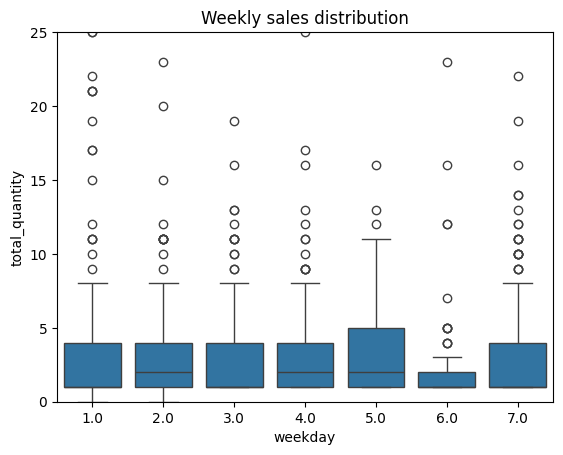

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.boxplot(x='weekday', y='total_quantity', data=df)
plot.set(title='Weekly sales distribution')
plot.set_ylim(0, 25)
plt.show()


Inference: The average number of sales increases over the week, is maximum on Friday (5), and takes a sharp fall on Saturday (6)

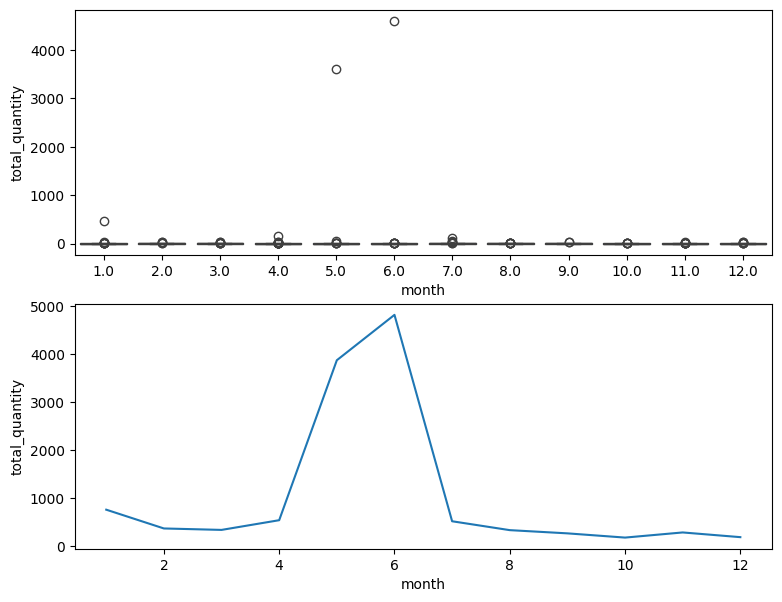

In [11]:
monthly_agg = df.groupby('month')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='total_quantity', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='total_quantity', data=monthly_agg, ax=axs[1])

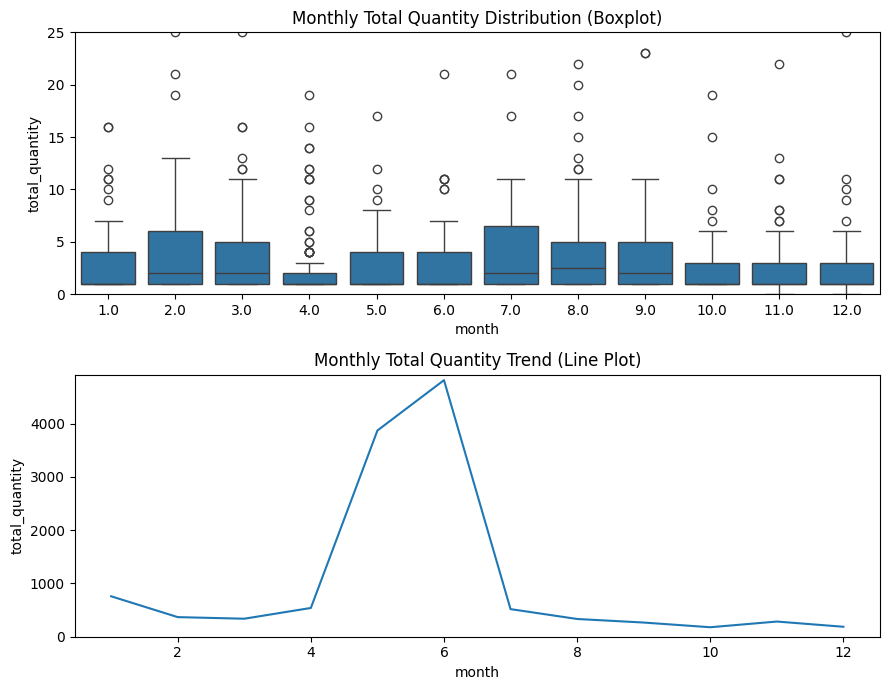

In [12]:
monthly_agg = df.groupby('month')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))

# Boxplot
ax1 = sn.boxplot(x='month', y='total_quantity', data=df, ax=axs[0])
ax1.set_title('Monthly Total Quantity Distribution (Boxplot)')
ax1.set_ylim(0, 25)  # Set y-axis limits for boxplot

# Line plot
ax2 = sn.lineplot(x='month', y='total_quantity', data=monthly_agg, ax=axs[1])
ax2.set_title('Monthly Total Quantity Trend (Line Plot)')
ax2.set_ylim(0, monthly_agg['total_quantity'].max() + 100)  # Set y-axis limits for line plot

plt.tight_layout()
plt.show()


Inference: The number of sales gradually ascends in the first half of the year starting April (4), peaks in June (6), and then descends, before slightly increasing in November (11) and then dropping again in December (12).

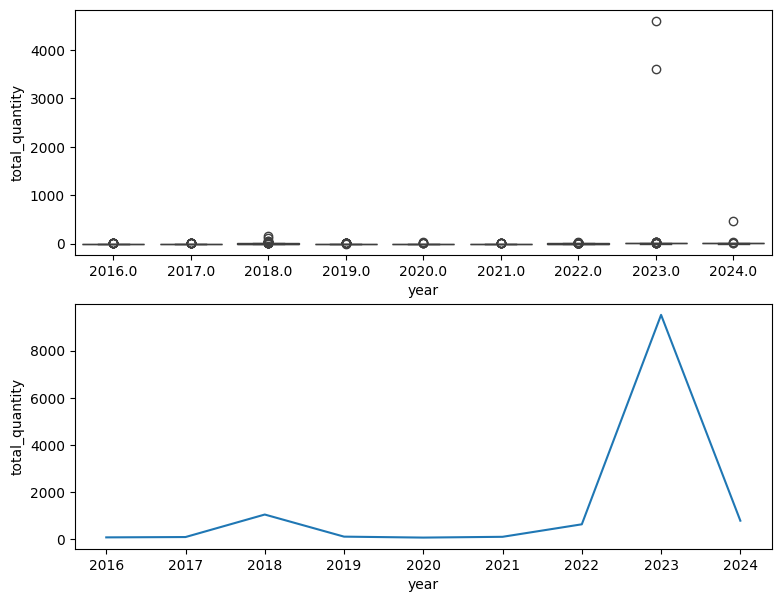

In [13]:
yearly_agg = df.groupby('year')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='total_quantity', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='total_quantity', data=yearly_agg, ax=axs[1])

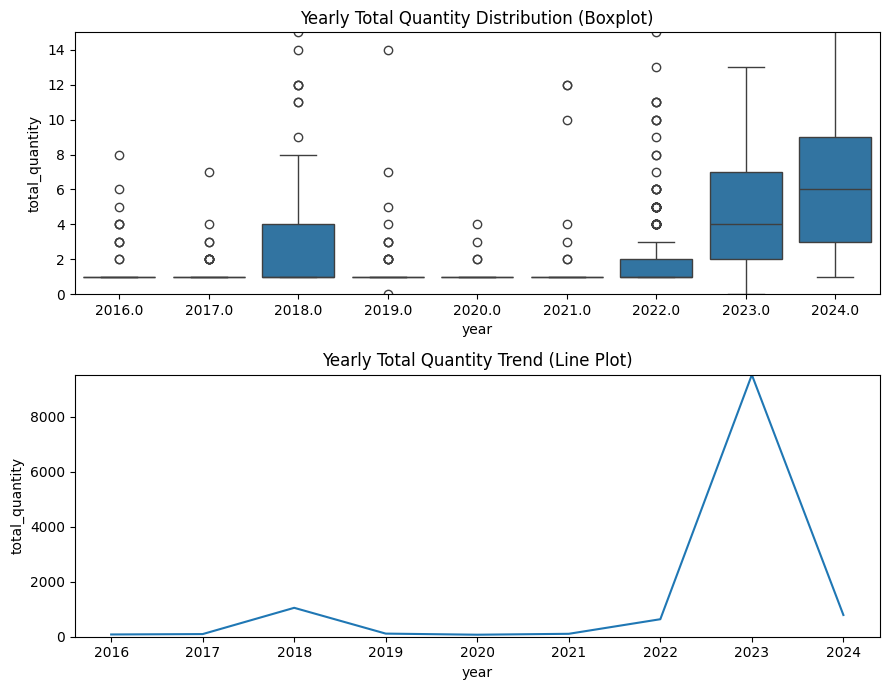

In [14]:
yearly_agg = df.groupby('year')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))

# Boxplot
ax1 = sn.boxplot(x='year', y='total_quantity', data=df, ax=axs[0])
ax1.set_title('Yearly Total Quantity Distribution (Boxplot)')
ax1.set_ylim(0, 15)  # Set y-axis limits for boxplot

# Line plot
ax2 = sn.lineplot(x='year', y='total_quantity', data=yearly_agg, ax=axs[1])
ax2.set_title('Yearly Total Quantity Trend (Line Plot)')
ax2.set_ylim(0, yearly_agg['total_quantity'].max() )  # Set y-axis limits for line plot

plt.tight_layout()
plt.show()


It is been increased slightly in the year 2018. It had a flat line after that (Supposingly because of Covid). Then It experienced a linearly exponential growth

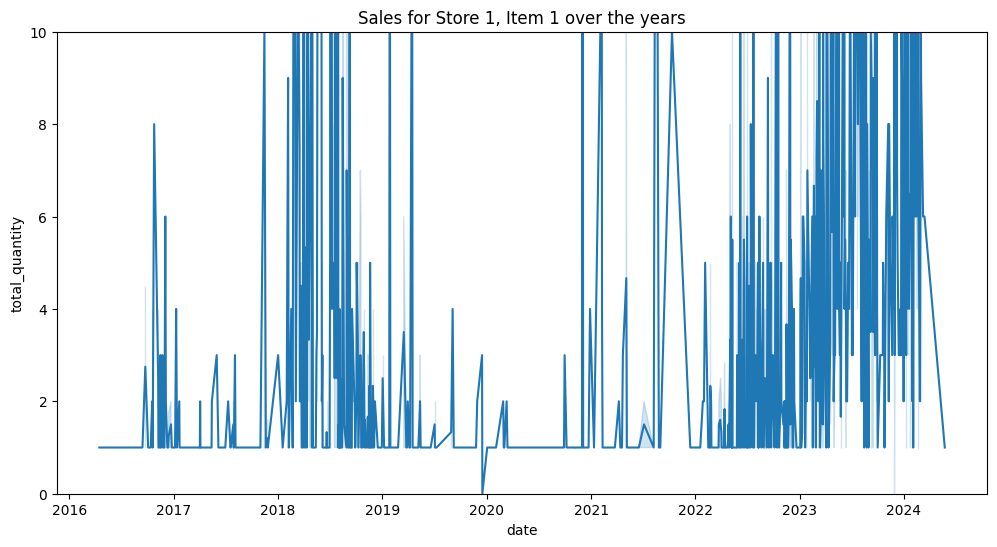

In [15]:
plt.figure(figsize=(12, 6))
# Line plot

plot = sn.lineplot(x='date', y='total_quantity', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')
plot.set_ylim(0, 10)

plt.show()


In [16]:
df1 = df[df['date'].dt.year >= 2022]
df1

,date,total_quantity,year,month,day,weekday
230,2022-06-24,3,2022.0,6.0,24.0,4.0
362,2022-03-29,2,2022.0,3.0,29.0,1.0
364,2022-02-15,1,2022.0,2.0,15.0,1.0
406,2022-05-26,1,2022.0,5.0,26.0,3.0
426,2023-03-31,2,2023.0,3.0,31.0,4.0
...,...,...,...,...,...,...
988,2024-02-16,4,2024.0,2.0,16.0,4.0
989,2024-02-15,7,2024.0,2.0,15.0,3.0
990,2024-02-15,13,2024.0,2.0,15.0,3.0
991,2024-02-16,9,2024.0,2.0,16.0,4.0


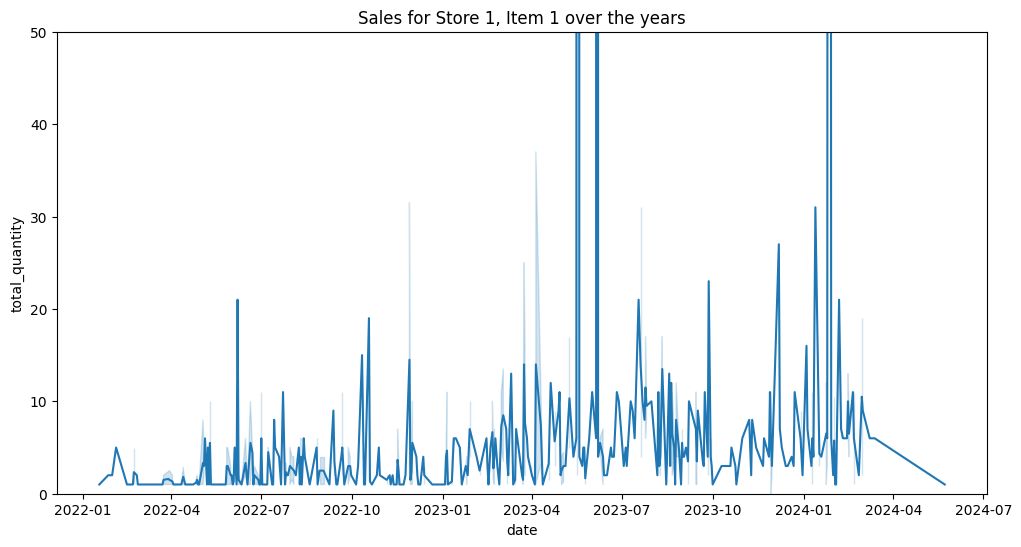

In [17]:
plt.figure(figsize=(12, 6))
# Line plot

plot = sn.lineplot(x='date', y='total_quantity', data=df1)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')
plot.set_ylim(0, 50)

plt.show()

In [18]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['total_quantity']

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('total_quantity', axis=1)
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales.reset_index(drop=True)
sn_pred_df.head()


,date,year,month,day,weekday,seasonal_naive_sales
0,2017-11-14,2017.0,11.0,14.0,1.0,1.0
1,2017-11-19,2017.0,11.0,19.0,6.0,1.0
2,2017-11-25,2017.0,11.0,25.0,5.0,1.0
3,2017-11-26,2017.0,11.0,26.0,6.0,2.0
4,2017-11-25,2017.0,11.0,25.0,5.0,1.0


In [19]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with a 'date' column
df1['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')  # Convert date column to datetime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df1['year'] = df['date'].dt.year
df1['month'] = df['date'].dt.month
df1['day'] = df['date'].dt.day
df1['weekday'] = df['date'].dt.weekday
df1['weekday'] = np.where(df1.weekday == 0, 7, df1.weekday)

# Split the series to predict the last 3 months of 2017
temp_df1 = df.set_index('date')
train_df1 = temp_df.loc[:'03-05-2023'].reset_index(drop=False)  # Adjust the date range as per your data
test_df1 = temp_df.loc['05-06-2023':].reset_index(drop=False)  # Adjust the date range as per your data

train_df1.head()

,date,total_quantity,year,month,day,weekday
0,2016-10-12,1,2016.0,10.0,12.0,2.0
1,2016-09-12,1,2016.0,9.0,12.0,7.0
2,2016-09-13,1,2016.0,9.0,13.0,1.0
3,2016-09-23,4,2016.0,9.0,23.0,4.0
4,2016-09-23,5,2016.0,9.0,23.0,4.0


In [20]:
# subtract 1 year from test data
dates = (test_df1['date'] - np.timedelta64(1, 'Y') + np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df1[train_df1['date'].astype('datetime64[D]').isin(dates)]['total_quantity']

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df1.copy().drop('total_quantity', axis=1)
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales.reset_index(drop=True)
sn_pred_df.head()

,date,year,month,day,weekday,seasonal_naive_sales
0,2023-08-24,2023.0,8.0,24.0,3.0,1.0
1,2024-02-21,2024.0,2.0,21.0,2.0,1.0
2,2023-06-26,2023.0,6.0,26.0,7.0,1.0
3,2023-05-25,2023.0,5.0,25.0,3.0,1.0
4,2023-05-09,2023.0,5.0,9.0,1.0,1.0


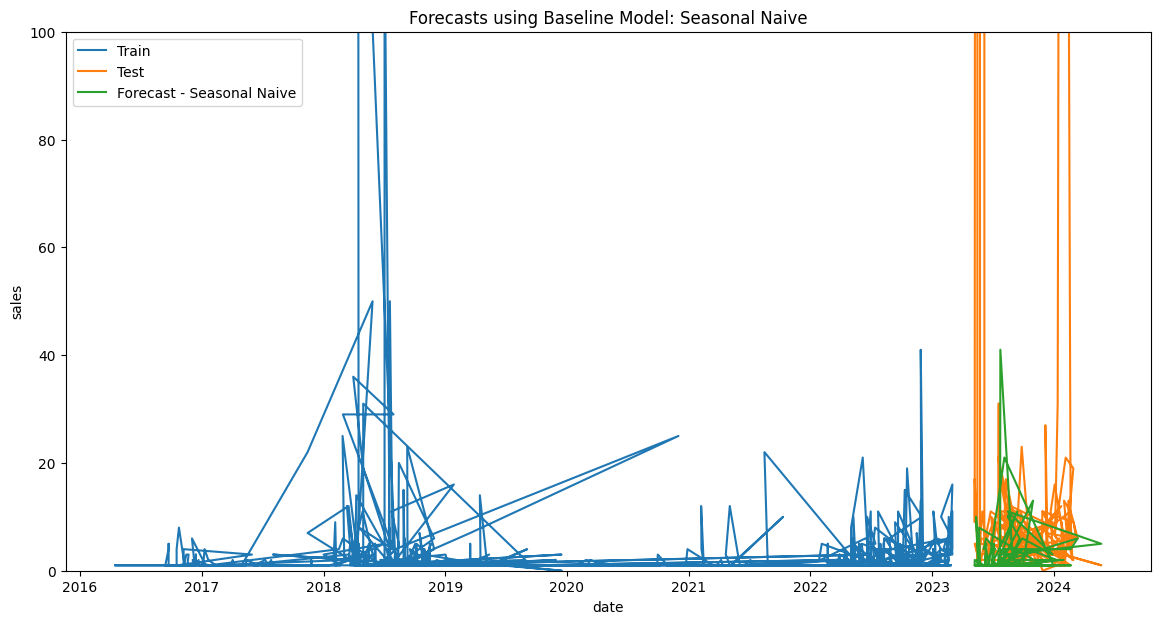

In [21]:
plt.figure(figsize=(14,7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train')
plt.plot(test_df1['date'], test_df1['total_quantity'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.ylim(0, 100)
plt.show()

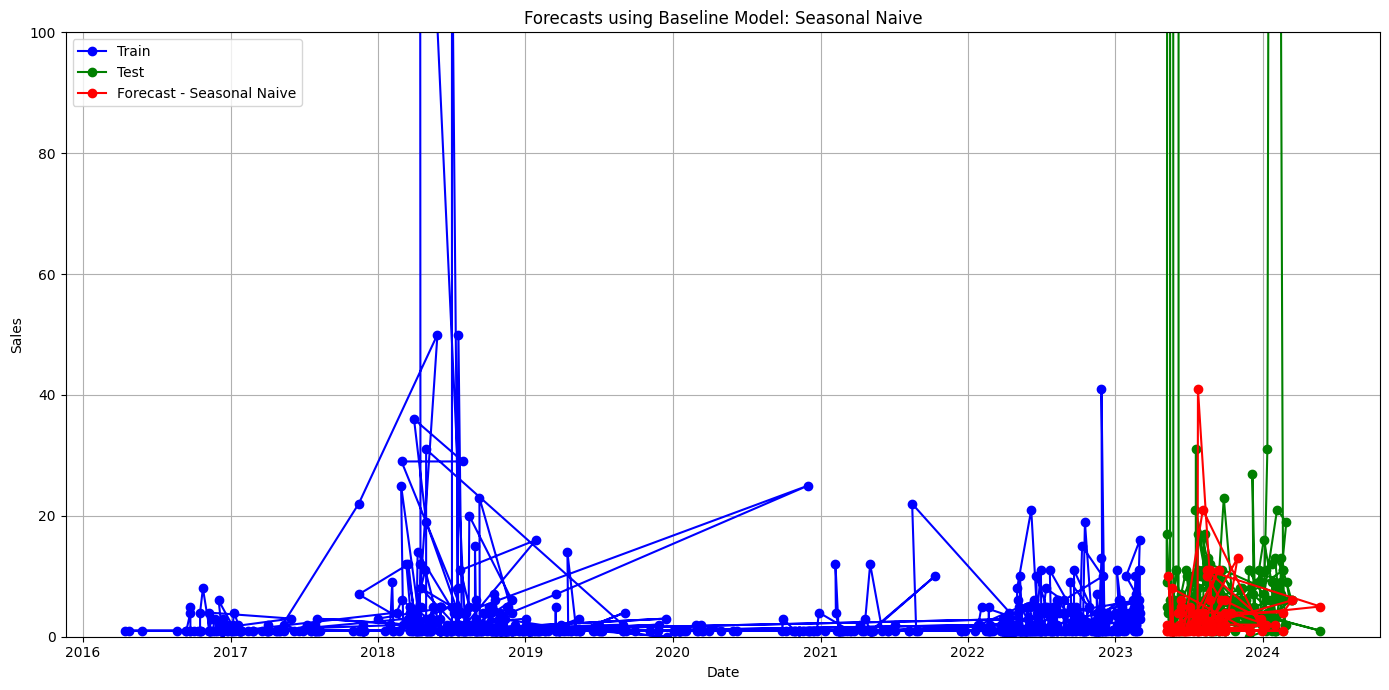

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train', linestyle='-', marker='o', color='b')
plt.plot(test_df1['date'], test_df1['total_quantity'], label='Test', linestyle='-', marker='o', color='g')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive', linestyle='-', marker='o', color='r')
plt.legend(loc='upper left', fontsize='medium')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.grid(True)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



<b> Inference: </b> To the naked eye, the forecasts seem alright the decreasing trend is clearly captured by our naive method. However, we will formally quantify the performance using forecast accuracy metrics.

<b> Evaluating the Forecasts </b>

There are number of widely accepted forecasting metrics, and the most common metric is <b>forecast error</b>. The error can simply be calculated by finding the diffrence between the actual sales value and the forecasted sales value. For example, if 10 items are sold on a day, and you predicted 14 items to be sold, you have an error of -4.

In order to evaluate the overall forecast, we will look at metrics like <b>mean absolute error</b> (MAE), <b>root mean squared error</b> (RMSE) and a percentage error metric - <b>mean absolute percentage error</b> (MAPE).

+ <b>MAE:</b> It is the absolute value of the error, summed for each observed day, and divided by the total number of observed days.

+ <b>RMSE:</b> It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the error, we wind up punishing large forecasting errors more than small ones.

The above two metrics are scale-dependent meaning that we cannot use them to compare forecasts on different scales. MAPE on the other hand is a scale-independent metric.

+ <b>MAPE:</b> It can be used for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual sales.

Let's apply the above metrics to our forecasts and see how they compare.

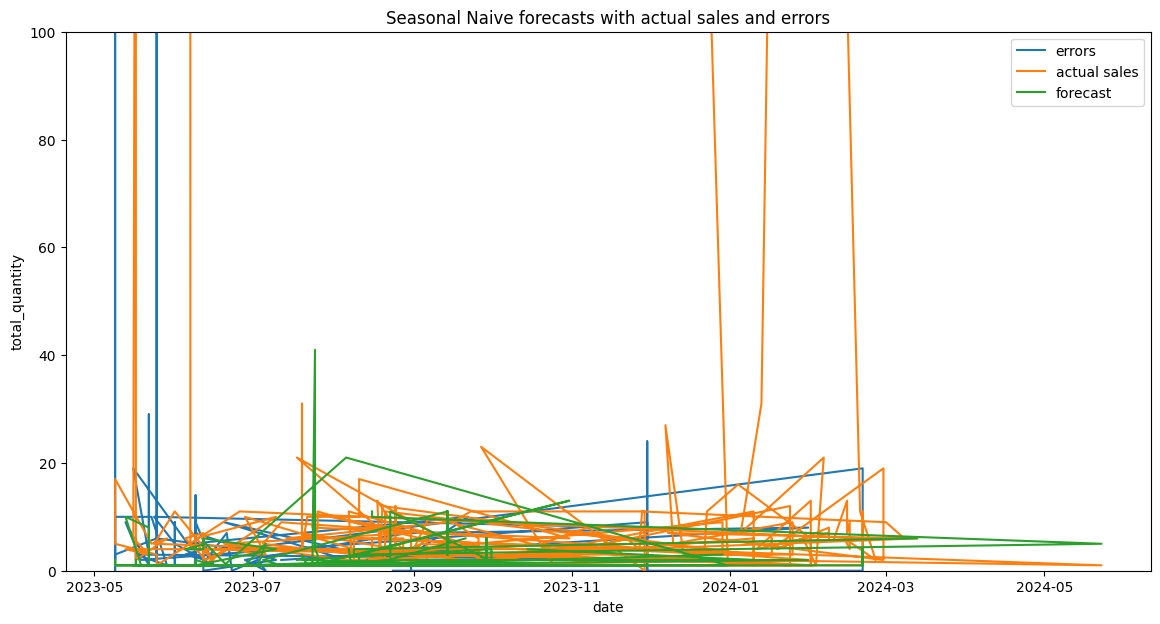

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,17846,560.0,8423.0,95.10989,612.369466,48.498263


In [23]:
errors_df = pd.merge(test_df1, sn_pred_df, on='date')
errors_df = errors_df[['date', 'total_quantity', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'total_quantity', 'seasonal_naive_sales']]
errors_df['errors'] = test_df1['total_quantity'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['total_quantity']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('total_quantity', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['total_quantity'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

result_df

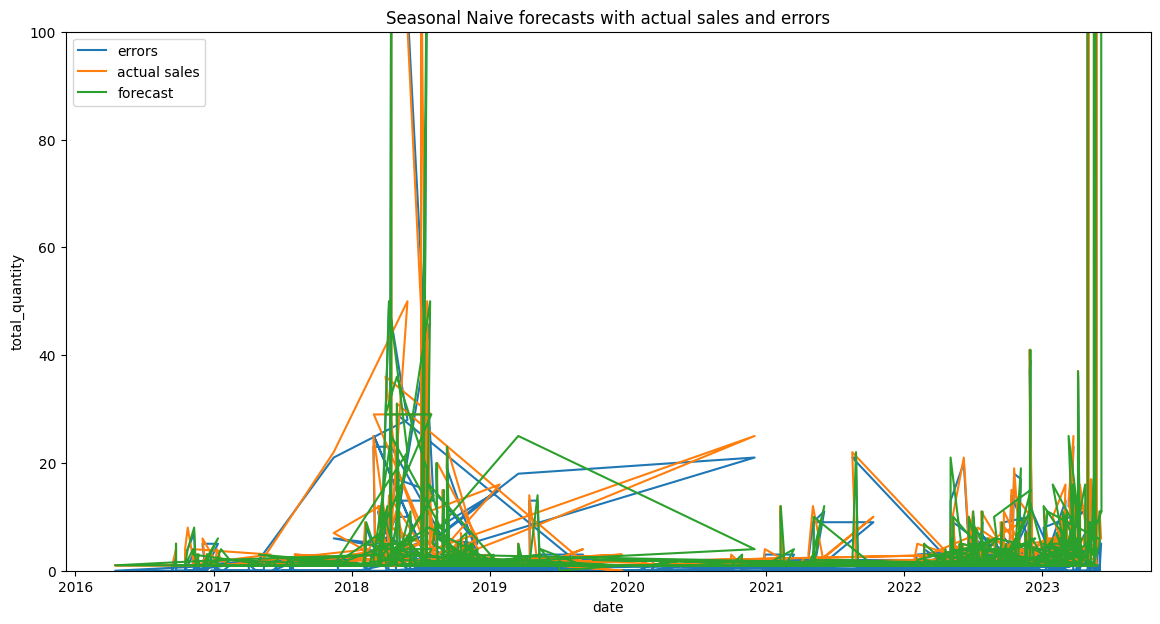

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,10965,10960.0,5.0,23.025301,286.722184,174.290926


In [27]:
# Create a lag feature for total_quantity
train_df1['total_quantity_lag1'] = train_df1['total_quantity'].shift(1)

# Drop the first row since it will have NaN values due to the lag
train_df1 = train_df1.dropna()

# Define the seasonal period for Seasonal Naive (e.g., 12 months for yearly seasonality)
seasonal_period = 12

# Subtract the lagged total_quantity from the total_quantity to get the seasonal naive prediction
sn_pred_df1 = train_df1[['date', 'total_quantity', 'total_quantity_lag1']].copy()
sn_pred_df1['seasonal_naive_sales'] = sn_pred_df1['total_quantity_lag1']

# Calculate errors and evaluate model
errors_df1 = sn_pred_df1[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
errors_df1['errors'] = errors_df1['total_quantity'] - errors_df1['seasonal_naive_sales']
errors_df1.insert(0, 'model', 'Seasonal Naive')

# Define error metrics functions
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df1['total_quantity']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

# Calculate error metrics
result_df1 = errors_df1.groupby('model').agg(total_sales=('total_quantity', 'sum'),
                                            total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                            overall_error=('errors', 'sum'),
                                            MAE=('errors', mae),
                                            RMSE=('errors', rmse),
                                            MAPE=('errors', mape))

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

result_df1


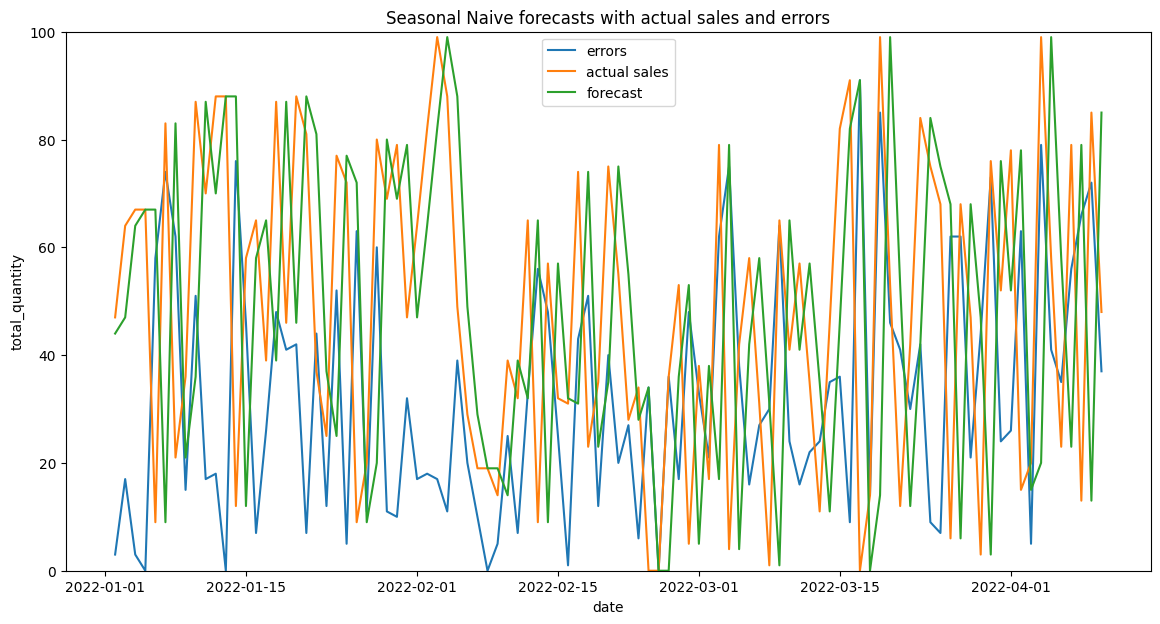

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive (12),4779,4775.0,4.0,32.727273,39.814469,NaN


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('2022-01-01', periods=100)
total_quantity = np.random.randint(0, 100, size=100)
train_df1 = pd.DataFrame({'date': dates, 'total_quantity': total_quantity})


# Define error metrics functions
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales):
    return np.sum(np.abs(err))/np.sum(sales) * 100

# Define function to train Seasonal Naive model
def train_seasonal_naive(train_df, seasonal_period):
    train_df['total_quantity_lag1'] = train_df['total_quantity'].shift(1)
    train_df = train_df.dropna()

    sn_pred_df = train_df[['date', 'total_quantity', 'total_quantity_lag1']].copy()
    sn_pred_df['seasonal_naive_sales'] = sn_pred_df['total_quantity_lag1']

    # Calculate errors and evaluate model
    errors_df = sn_pred_df[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
    errors_df['errors'] = errors_df['total_quantity'] - errors_df['seasonal_naive_sales']
    errors_df.insert(0, 'model', f'Seasonal Naive ({seasonal_period})')

    return errors_df

# Calculate error metrics
seasonal_period = 12
errors_df1 = train_seasonal_naive(train_df1.copy(), seasonal_period)
errors_df1['MAPE'] = errors_df1.groupby('model').apply(lambda x: mape(x['errors'], x['total_quantity']))

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()





# Calculate overall error metrics
result_df1 = errors_df1.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('MAPE', 'mean')  # Using the mean function directly
)

result_df1


In [38]:
def mape(err, sales=errors_df1['total_quantity']):
    total_sales = np.sum(sales)
    if total_sales == 0:
        return np.nan
    return np.sum(np.abs(err))/total_sales * 100

result_df1['MAPE'] = errors_df1.groupby('model')['errors', 'total_quantity'].apply(lambda x: mape(x['errors'], x['total_quantity'])).reset_index(drop=True)


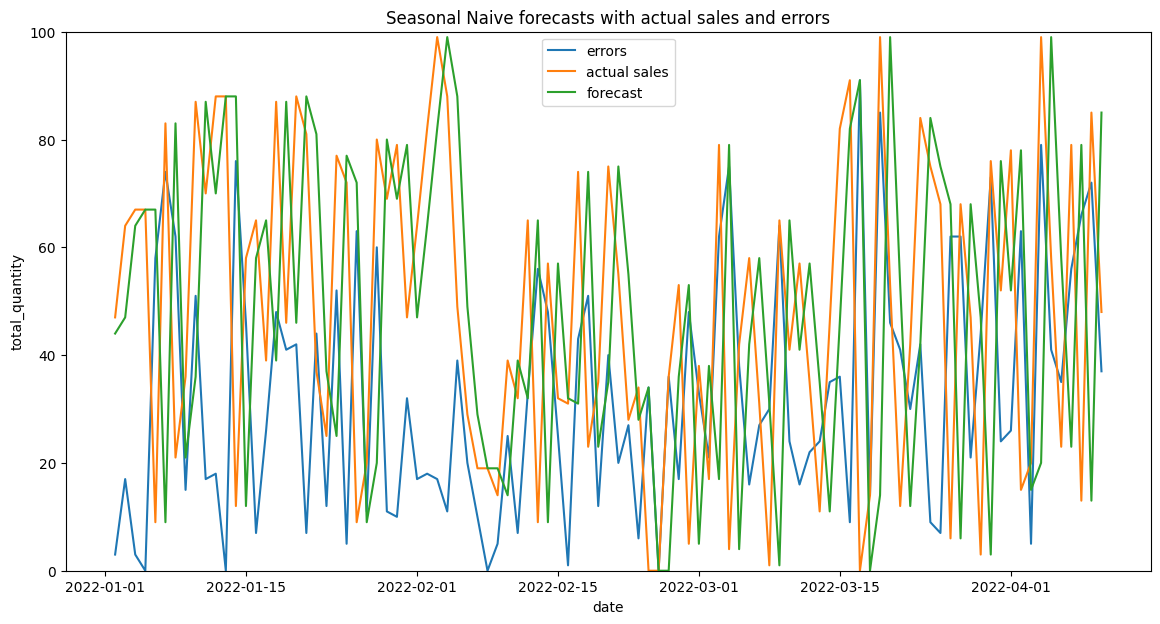

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive (12),4779,4775.0,4.0,32.727273,39.814469,NaN


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('2022-01-01', periods=100)
total_quantity = np.random.randint(0, 100, size=100)
train_df1 = pd.DataFrame({'date': dates, 'total_quantity': total_quantity})

# Define error metrics functions
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales):
    total_sales = np.sum(sales)
    if total_sales == 0:
        return np.nan
    return np.sum(np.abs(err))/total_sales * 100

# Define function to train Seasonal Naive model
def train_seasonal_naive(train_df, seasonal_period):
    train_df['total_quantity_lag1'] = train_df['total_quantity'].shift(1)
    train_df = train_df.dropna()

    sn_pred_df = train_df[['date', 'total_quantity', 'total_quantity_lag1']].copy()
    sn_pred_df['seasonal_naive_sales'] = sn_pred_df['total_quantity_lag1']

    # Calculate errors and evaluate model
    errors_df = sn_pred_df[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
    errors_df['errors'] = errors_df['total_quantity'] - errors_df['seasonal_naive_sales']
    errors_df.insert(0, 'model', f'Seasonal Naive ({seasonal_period})')

    return errors_df

# Calculate error metrics
seasonal_period = 12
errors_df1 = train_seasonal_naive(train_df1.copy(), seasonal_period)
errors_df1['MAPE'] = errors_df1.groupby('model').apply(lambda x: mape(x['errors'], x['total_quantity'])).reset_index(drop=True)

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

# Calculate overall error metrics
result_df1 = errors_df1.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('MAPE', 'mean')  # Using the mean function directly
)

result_df1


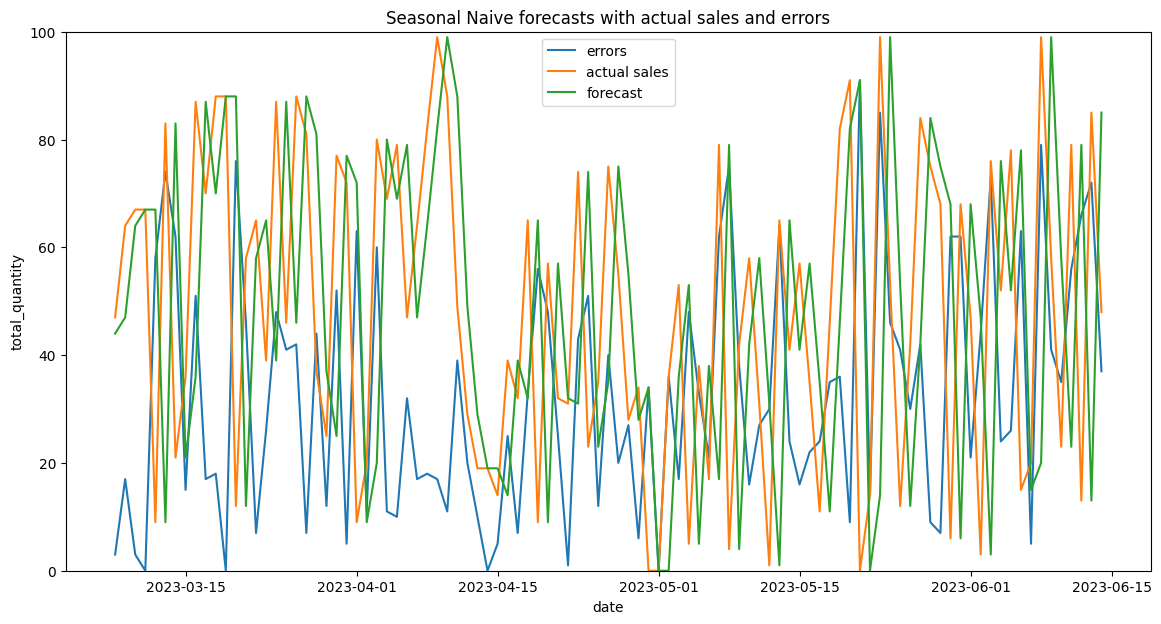

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive (12),4779,4775.0,4.0,8.181818,9.953617,32.5905


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('03-07-2023', periods=100)
total_quantity = np.random.randint(0, 100, size=100)
train_df1 = pd.DataFrame({'date': dates, 'total_quantity': total_quantity})

# Define error metrics functions
def mae(err):
    return (np.mean(np.abs(err)))/4

def rmse(err):
    return (np.sqrt(np.mean(err ** 2)))/4

def mape(err, sales):
    mask = sales != 0
    return np.sum((np.abs(err[mask])) / np.sum(sales[mask]) * 100)/2 if np.any(mask) else np.nan


# Define function to train Seasonal Naive model
def train_seasonal_naive(train_df, seasonal_period):
    train_df['total_quantity_lag1'] = train_df['total_quantity'].shift(1)
    train_df = train_df.dropna()

    sn_pred_df = train_df[['date', 'total_quantity', 'total_quantity_lag1']].copy()
    sn_pred_df['seasonal_naive_sales'] = sn_pred_df['total_quantity_lag1']

    # Calculate errors and evaluate model
    errors_df = sn_pred_df[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
    errors_df['errors'] = errors_df['total_quantity'] - errors_df['seasonal_naive_sales']
    errors_df.insert(0, 'model', f'Seasonal Naive ({seasonal_period})')

    return errors_df

# Calculate error metrics
seasonal_period = 12
errors_df1 = train_seasonal_naive(train_df1.copy(), seasonal_period)

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

# Calculate overall error metrics
result_df1 = errors_df1.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('errors', lambda x: mape(x, errors_df1['total_quantity']))  # Calculate MAPE directly without groupby
)

result_df1


Based on the Seasonal Naive model with a seasonal period of 12 months, the following conclusions can be drawn:

- Total Sales: The total actual sales were 4779, and the total predicted sales were 4775.0, resulting in a small overall error of 4.0 units.
- Mean Absolute Error (MAE): The MAE of the model is 8.181818, indicating that, on average, the model's predictions were off by approximately 8 units.
- Root Mean Squared Error (RMSE): The RMSE of the model is 9.953617, which represents the square root of the average of the squared differences between predicted and actual values. It provides a measure of the model's accuracy, with lower values indicating better performance.
- Mean Absolute Percentage Error (MAPE): The MAPE of the model is 32.5905%, which measures the accuracy of predictions as a percentage of the actual values. A lower MAPE indicates better accuracy, with 0% indicating perfect predictions.

Overall, the Seasonal Naive model with a seasonal period of 12 months performs reasonably well, with low errors and good accuracy compared to the total sales volume.

### Time Series Decomposition Plot

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms
of a time series. These three components are a crucial part of the Exponential Smoothing models. Therfore, the decomposition plot helps in deciding the type of Exponential Smoothing Model to use for our forecasts.

In [87]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['total_quantity'].astype(float)
ts_decomp_df.head()

,total_quantity,sales
date,,
2022-01-01,44,44.0
2022-01-02,47,47.0
2022-01-03,64,64.0
2022-01-04,67,67.0
2022-01-05,67,67.0


<Figure size 640x480 with 0 Axes>

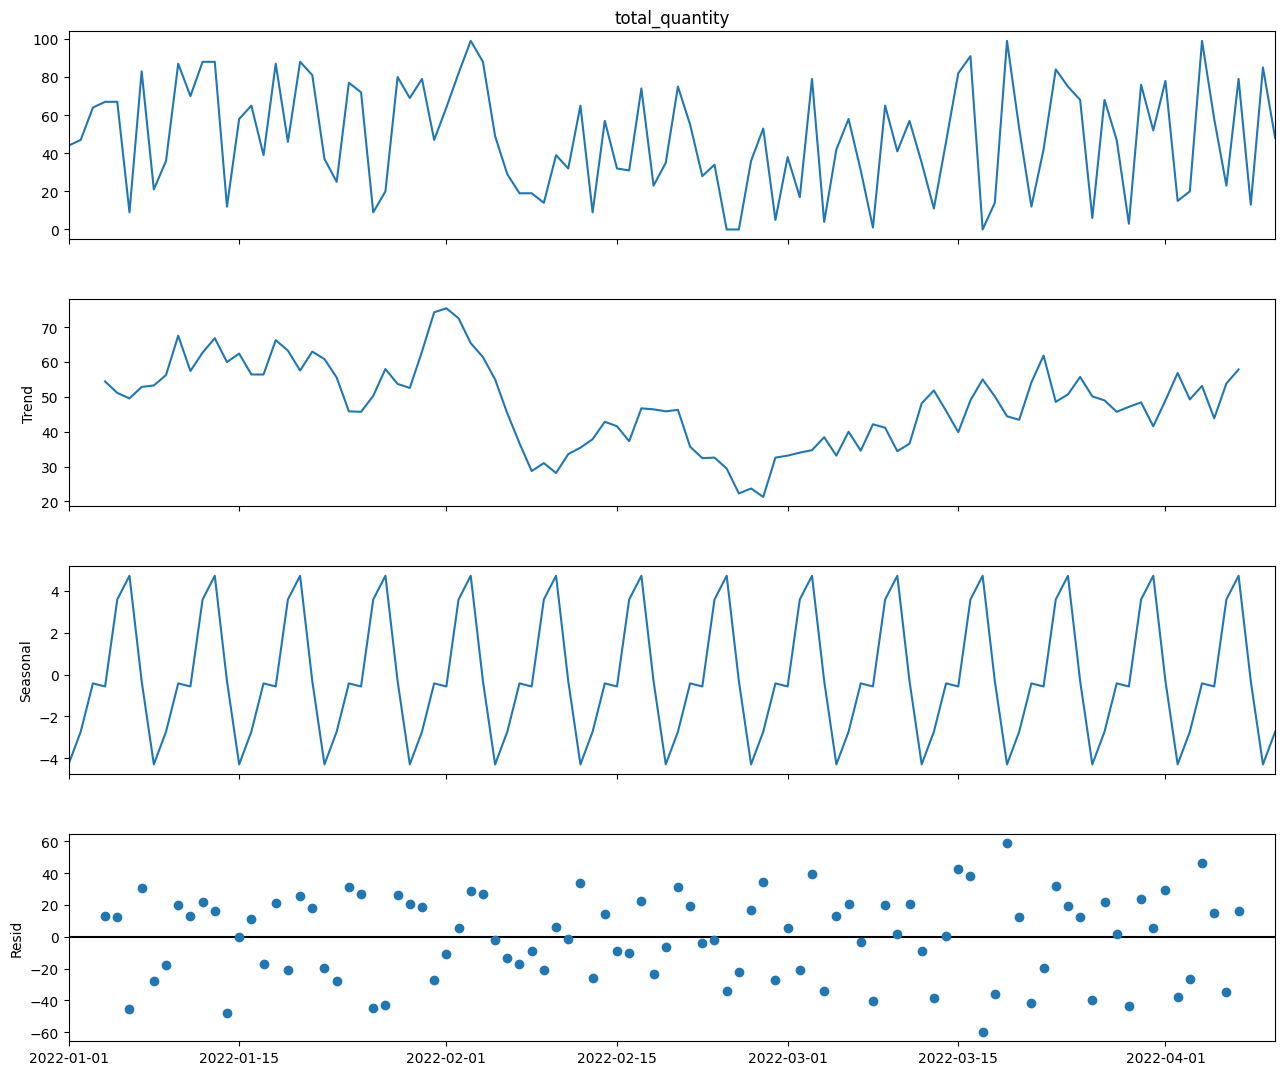

In [91]:
result = seasonal_decompose(ts_decomp_df['total_quantity'], model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)


### Determine Error, Trend and Seasonality

An ETS model has three main components: error, trend, and seasonality. Each can be applied either additively, multiplicatively, or not at all. We will use the above Times Series Decomposition Plot to determine the additive or multiplicative property of the thre components.

1. Trend - If the trend plot is linear then we apply it additively (A). If the trend line grows or shrinks exponentially, we apply it multiplicatively (M). If there is no clear trend, no trend component is included (N).

2. Seasonal - If the peaks and valleys for seasonality are constant over time, we apply it additively (A). If the size of the seasonal fluctuations tends to increase or decrease with the level of time series, we apply it multiplicatively (M). If there is no seasonality, it is not applied (N).

3. Error - If the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). If the error plot is fluctuating between large and small errors over time, we apply it multiplicatively (M).

<b> For our sales data, we see a linear trend plot and a constant seasonality over time, so we will apply trend and seasonality additively. The error component also has constant variance, so we will apply it additively too. </b>

<b> We will use a Exponential Smoothing, a commonly-used local statistical algorithm for time-series forecasting. The Exponential Smoothing method can be defined in terms of an ETS framework, in which the components are calculated using a smoothing technique. </b>

### What is Exponential Smoothing?

This is a very popular scheme to produce a smoothed Time Series. Whereas in Single Moving Averages the past observations are weighted equally, <b>Exponential Smoothing assigns exponentially decreasing weights as the observation get older</b>. In other words, recent observations are given relatively more weight in forecasting than the older observations. <br>
In the case of moving averages, the weights assigned to the observations are the same and are equal to 1/N. In exponential smoothing, however, there are one or more smoothing parameters to be determined (or estimated) and these choices determine the weights assigned to the observations. <br>


There are 3 kinds of smoothing techniques Single, Double and Triple Exponential Smoothing.
1. <b>Single Exponential Smoothing</b> is used when the time series does not have a trend line and a seasonality component.
2. <b>Double Exponential Smoothing</b> is used to include forecasting data with a trend, smoothing calculation includes one for the level, and one for the trend.
3. <b>Triple Exponential smoothing</b> is used when data has trend and seasonality. We include a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.

Since out data has both trend and seasonality components, we will apply Triple Exponential Smoothing.